## What Do GNNs Actually Learn? Towards Understanding their Representations

Here we reproduce some of the experiments of the paper [What Do GNNs Actually Learn? Towards Understanding their Representations](https://openreview.net/pdf?id=OjHWbOsrBk).

We first compare the distances of the representations learned by GCN and GIN against the corresponding differences in the sum of normalized walks and number of walks, respectively. We perform our experiments on the IMDB-BINARY dataset. Since nodes of the graphs of IMDB-BINARY are not annotated with any features, we annotate them with a single feature equal to 0.1. We also randomly split the dataset into a training, a validation and a test set with an 80 : 10 : 10 split ratio.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import diags, identity
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import euclidean_distances

import torch
import torch.nn as nn

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GINConv, GCNConv, global_add_pool
from torch_geometric.utils import degree
from torch_geometric.utils.convert import from_networkx, to_networkx, to_scipy_sparse_matrix

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Ones(object):
    def __call__(self, data):
        data.x = 0.1*torch.ones(data.num_nodes, 1, dtype=torch.float)
        return data
    
dataset = TUDataset(root='./datasets/IMDB-BINARY', name='IMDB-BINARY', transform=Ones())
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [800, 100, 100])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

We next define the `sum_walks` function which takes a NetworkX graph as input and outputs the number of walks or sum of normalized walks of length `length` that emanate from each node of the graph.

In [2]:
def sum_walks(G, length, normalize=False, selfloops=True):
    A = nx.to_scipy_sparse_array(G)
    n = A.shape[0]
    A = A + identity(n)
    if normalize:
        degrees = A.sum(axis=0)
        inv_degrees = np.power(degrees, -0.5)
        D_inv = diags(np.squeeze(np.asarray(inv_degrees)))
        A = D_inv @ A @ D_inv
    x = np.ones(n)
    for _ in range(length):
        x = A.dot(x)

    return x

G = to_networkx(train_set[0])
print(sum_walks(G, 2))

[ 37.  37.  40.  55. 105.  47.  47.  40.  47.  40.  37.  47.  40.  37.
  40.  40.  47.]


We next define a GCN model. The neighborhood aggregation layers are followed by a sum readout function and the emerging graph representation is fed to a 2-layers MLP.

In [3]:
class GCN(nn.Module):
    def __init__(self, hidden_dim, n_layers, n_class, dropout):
        super().__init__()
        self.n_layers = n_layers

        lst = [GCNConv(1, hidden_dim, bias=False)]
        for i in range(n_layers-1):
            lst.append(GCNConv(hidden_dim, hidden_dim, bias=False))
        self.conv = nn.ModuleList(lst)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_class)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.n_layers):
            x = self.relu(self.conv[i](x, edge_index))
            x = self.dropout(x)

        out = global_add_pool(x, data.batch)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out, x

We initialize an instance of the GCN model and train it on the training set of the IMDB-BINARY dataset. We store the representations of the nodes of the graphs that belong to the test set in `z_test`. Those representations are generated by the model that achieved the lowest validation loss.

In [4]:
model = GCN(hidden_dim=64, n_layers=3, n_class=2, dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

best_val_loss = 100
for epoch in range(300):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    train_loss = loss_all / len(train_loader.dataset)
    
    model.eval()
    loss_all = 0
    for data in val_loader:
        data = data.to(device)
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss_all += data.num_graphs * loss.item()
    val_loss = loss_all / len(val_loader.dataset)

    if best_val_loss >= val_loss:
        best_val_loss = val_loss

        correct = 0
        z_test = list()
        for data in test_loader:
            data = data.to(device)
            output, z = model(data)
            z_test.append(z)
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
        z_test = torch.cat(z_test, dim=0)
        test_acc = correct / len(test_loader.dataset)
    
    if epoch % 50 == 0:
        print('Epoch: {:03d}, Train Loss: {:.7f}, '
                'Val Loss: {:.7f}, Test Acc: {:.7f}'.format(
                epoch+1, train_loss, val_loss, test_acc))

Epoch: 001, Train Loss: 0.6937188, Val Loss: 0.6935110, Test Acc: 0.5600000
Epoch: 051, Train Loss: 0.6910908, Val Loss: 0.6919807, Test Acc: 0.5000000
Epoch: 101, Train Loss: 0.6901847, Val Loss: 0.6900186, Test Acc: 0.4800000
Epoch: 151, Train Loss: 0.6892342, Val Loss: 0.6900063, Test Acc: 0.4900000
Epoch: 201, Train Loss: 0.6888606, Val Loss: 0.6912505, Test Acc: 0.4700000
Epoch: 251, Train Loss: 0.6885641, Val Loss: 0.6912056, Test Acc: 0.4700000


We compute the sum of normalized walks of length 3 for all the nodes of the graphs that belong to the test set. We then randomly choose 100 of those nodes and compute their distances using (1) the sum of normalized walks; and (2) their representations that were produced by GCN. We finally compute the correlation of the two collections of distances and we also visualize them. 

PearsonRResult(statistic=0.9999999931066418, pvalue=0.0)


Text(0, 0.5, '$ \\Vert \\mathbf{h}_u - \\mathbf{h}_v \\Vert $ ')

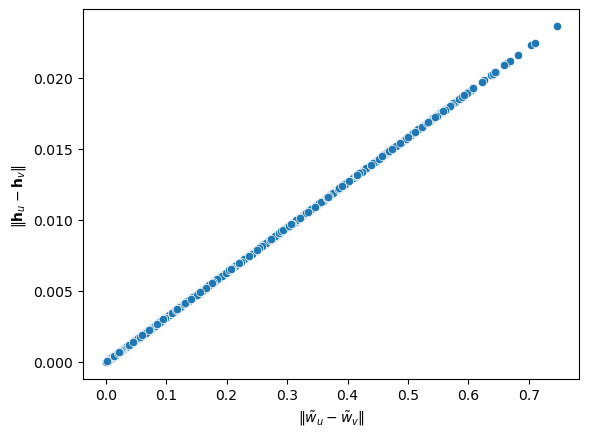

In [5]:
test_loader = DataLoader(test_set, batch_size=1)
walks = list()
for data in test_loader:
    G = to_networkx(data)
    w = sum_walks(G, length=3, normalize=True)
    walks.append(w.reshape(-1, 1))
walks = np.vstack(walks)

idx = np.random.permutation(z_test.size(0))[:100]

z_test_subset = z_test[idx,:]
dist_gcn = torch.cdist(z_test_subset, z_test_subset).cpu().detach().numpy()

walks_subset = walks[idx,:]
dist_walks = euclidean_distances(walks_subset, walks_subset)

inds = np.triu_indices(100, k=1)
print(pearsonr(dist_gcn[inds], dist_walks[inds]))

g = sns.scatterplot(x=dist_walks[inds], y=dist_gcn[inds])
plt.xlabel(r"$\Vert \tilde{w}_u - \tilde{w}_v \Vert$")
plt.ylabel(r'$ \Vert \mathbf{h}_u - \mathbf{h}_v \Vert $ ')

We next experiment with the GIN model. We define a model that consists of 3 neighborhood aggregation layers. The neighborhood aggregation layers are followed by a sum readout function and the emerging graph representation is fed to a 2-layers MLP.

In [6]:
class GIN(nn.Module):
    def __init__(self, hidden_dim, n_layers, n_class, dropout, bias=False):
        super().__init__()
        self.n_layers = n_layers

        lst = []
        if bias:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
        else:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))

        self.conv = nn.ModuleList(lst)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_class)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.n_layers):
            x = self.conv[i](x, edge_index)
            x = self.dropout(x)

        out = global_add_pool(x, data.batch)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out, x

We initialize an instance of the model and train it on the training set of the IMDB-BINARY dataset. We store the representations of the nodes of the graphs that belong to the test set in `z_test`. Those representations are generated by the model that achieved the lowest validation loss.

In [7]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

model = GIN(hidden_dim=64, n_layers=3, n_class=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

best_val_loss = 100
for epoch in range(300):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    train_loss = loss_all / len(train_loader.dataset)
    
    model.eval()
    loss_all = 0
    for data in val_loader:
        data = data.to(device)
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss_all += data.num_graphs * loss.item()
    val_loss = loss_all / len(val_loader.dataset)

    if best_val_loss >= val_loss:
        best_val_loss = val_loss

        correct = 0
        z_test = list()
        for data in test_loader:
            data = data.to(device)
            output, z = model(data)
            z_test.append(z)
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
        z_test = torch.cat(z_test, dim=0)
        test_acc = correct / len(test_loader.dataset)
    
    if epoch % 50 == 0:
        print('Epoch: {:03d}, Train Loss: {:.7f}, '
                'Val Loss: {:.7f}, Test Acc: {:.7f}'.format(
                epoch+1, train_loss, val_loss, test_acc))

Epoch: 001, Train Loss: 1.2119694, Val Loss: 0.6832054, Test Acc: 0.4600000
Epoch: 051, Train Loss: 0.6435484, Val Loss: 0.6180663, Test Acc: 0.6200000
Epoch: 101, Train Loss: 0.6327540, Val Loss: 0.6113712, Test Acc: 0.6600000
Epoch: 151, Train Loss: 0.6289055, Val Loss: 0.6097341, Test Acc: 0.6600000
Epoch: 201, Train Loss: 0.6217358, Val Loss: 0.6256467, Test Acc: 0.6300000
Epoch: 251, Train Loss: 0.6269149, Val Loss: 0.5998317, Test Acc: 0.6800000


We compute the number of walks of length 3 for all the nodes of the graphs that belong to the test set. We then randomly choose 100 of those nodes and compute their distances using (1) the number of walks; and (2) their representations that were produced by GIN. We finally compute the correlation of the two collections of distances and we also visualize them. 

PearsonRResult(statistic=0.9999999999742505, pvalue=0.0)


Text(0, 0.5, '$ \\Vert \\mathbf{h}_u - \\mathbf{h}_v \\Vert $ ')

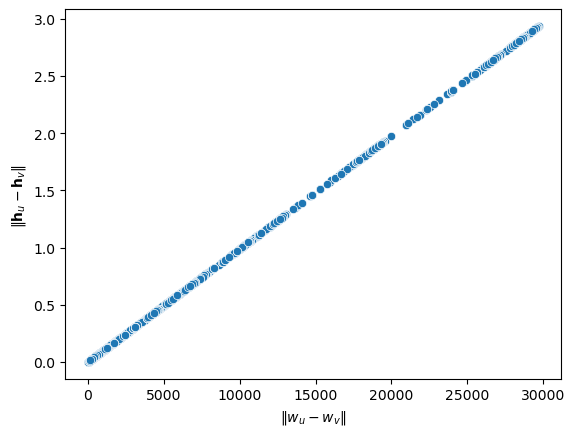

In [8]:
test_loader = DataLoader(test_set, batch_size=1)
walks = list()
for data in test_loader:
    G = to_networkx(data)
    w = sum_walks(G, length=3)
    walks.append(w.reshape(-1, 1))
walks = np.vstack(walks)

idx = np.random.permutation(z_test.size(0))[:100]

z_test_subset = z_test[idx,:]
dist_gcn = torch.cdist(z_test_subset, z_test_subset).cpu().detach().numpy()

walks_subset = walks[idx,:]
dist_walks = euclidean_distances(walks_subset, walks_subset)

inds = np.triu_indices(100, k=1)
print(pearsonr(dist_gcn[inds], dist_walks[inds]))

g = sns.scatterplot(x=dist_walks[inds], y=dist_gcn[inds])
plt.xlabel(r"$\Vert w_u - w_v \Vert$")
plt.ylabel(r'$ \Vert \mathbf{h}_u - \mathbf{h}_v \Vert $ ')

### Can Structurally Dissimilar Nodes Obtain Identical Representations?
We create the 3 graphs that are illustrated in Figure 2 in the paper.

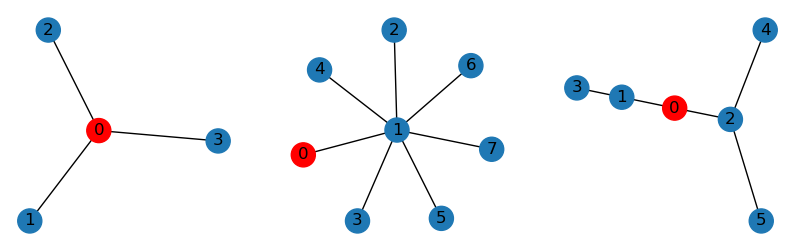

In [9]:
G1 = nx.Graph()
G1.add_edges_from([(0,1),(0,2),(0,3)])

G2 = nx.Graph()
G2.add_edges_from([(0,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7)])

G3 = nx.Graph()
G3.add_edges_from([(0,1),(0,2),(1,3),(2,4),(2,5)])

Gs = [G1, G2, G3]

f = plt.figure(figsize=(10,3))
for i in range(len(Gs)):
    f.add_subplot(1,3,i+1)
    node_color = ['#1f78b4']*Gs[i].number_of_nodes()
    node_color[0] = 'red'
    nx.draw(Gs[i], with_labels=True, node_color=node_color)

The number of walks of length 2 starting from the red nodes of the 3 graphs is equal to
10. Let $v, u, z$ denote the 3 nodes. Then, we have that $w_v^{(2)} = w_u^{(2)} = w_z^{(2)} = 10$. Therefore, for any pair of those 3 nodes (e.g., nodes $v$ and $u$), we have that $|| w_v^{(2)} - w_u^{(2)}|| = 0$. According to Theorem 1 from the paper, if the 3 graphs are fed to a GIN model without biases, then $\mathbf{h}_v^{(2)} = \mathbf{h}_u^{(2)} = \mathbf{h}_z^{(2)}$. We next empirically validate this result.

In [10]:
class GIN(nn.Module):
    def __init__(self, hidden_dim, n_layers, bias=False):
        super().__init__()
        self.n_layers = n_layers

        lst = []
        if bias:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
        else:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))

        self.conv = nn.ModuleList(lst)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.n_layers):
            x = self.conv[i](x, edge_index)

        return x
    
model = GIN(hidden_dim=8, n_layers=2, bias=False)

for G in Gs:
    data = from_networkx(G)
    data.x = torch.ones(G.number_of_nodes(), 1, dtype=torch.float)
    z = model(data)
    print(z[0,:])

tensor([0.0000, 0.0000, 0.3635, 0.0267, 0.0000, 0.0000, 0.0166, 0.4330],
       grad_fn=<SliceBackward0>)
tensor([0.0000, 0.0000, 0.3635, 0.0267, 0.0000, 0.0000, 0.0166, 0.4330],
       grad_fn=<SliceBackward0>)
tensor([0.0000, 0.0000, 0.3635, 0.0267, 0.0000, 0.0000, 0.0166, 0.4330],
       grad_fn=<SliceBackward0>)


We observe that all 3 red nodes obtain identical representations. Note that $w_v^{(1)} \neq w_u^{(1)}$, $w_v^{(1)} \neq w_z^{(1)}$ and $w_u^{(1)} \neq w_z^{(1)}$. Therefore, the representations of the 3 nodes produced at the first layer of GIN can be different from each if weights are properly initialized.

___ 

We next create the 2 graphs that are illustrated in Figure 3 in the paper.

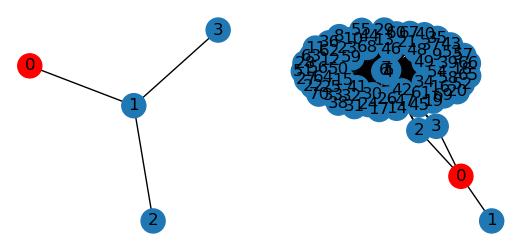

In [11]:
G1 = nx.Graph()
G1.add_edges_from([(0,1),(1,2),(1,3)])

G2 = nx.Graph()
G2.add_edges_from([(0,1),(0,2),(0,3),(2,4),(2,5),(3,6),(3,7)])
for i in range(4,8):
    for j in range(8,71):
        G2.add_edge(i,j)

Gs = [G1, G2]

f = plt.figure(figsize=(10,3))
for i in range(len(Gs)):
    f.add_subplot(1,3,i+1)
    node_color = ['#1f78b4']*Gs[i].number_of_nodes()
    node_color[0] = 'red'
    nx.draw(Gs[i], with_labels=True, node_color=node_color)

The sum of normalized walks of length 2 starting from the red nodes of the 2 graphs is approximately equal to
0.890. Let $v, u$ denote the 2 nodes. Then, we have that $\tilde{w}_v^{(2)} = \tilde{w}_u^{(2)} = \tilde{w}_z^{(2)} \approx 0.890$. Therefore, we have that $|| \tilde{w}_v^{(2)} - \tilde{w}_u^{(2)}|| = 0$. According to Theorem 1 from the paper, if the above 2 graphs are fed to a GCN model, then $||\mathbf{h}_v^{(2)} - \mathbf{h}_u^{(2)}|| = 0$, i.e., $\mathbf{h}_v^{(2)} = \mathbf{h}_u^{(2)}$. We next empirically validate this result.

In [12]:
class GCN(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super().__init__()
        self.n_layers = n_layers

        lst = [GCNConv(1, hidden_dim, bias=False)]
        for i in range(n_layers-1):
            lst.append(GCNConv(hidden_dim, hidden_dim, bias=False))
        self.conv = nn.ModuleList(lst)
        
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.n_layers):
            x = self.relu(self.conv[i](x, edge_index))
        
        return x
    
model = GCN(hidden_dim=8, n_layers=2)

for G in Gs:
    data = from_networkx(G)
    data.x = torch.ones(G.number_of_nodes(), 1, dtype=torch.float)
    z = model(data)
    print(z[0,:])

tensor([0.3076, 0.0000, 0.0000, 0.2050, 0.3641, 0.0000, 0.0000, 0.0750],
       grad_fn=<SliceBackward0>)
tensor([0.3074, 0.0000, 0.0000, 0.2049, 0.3639, 0.0000, 0.0000, 0.0749],
       grad_fn=<SliceBackward0>)


We observe that both red nodes obtain identical representations (or nearly identical due to numerical issues). Note that $\tilde{w}_v^{(1)} \neq \tilde{w}_u^{(1)}$. Therefore, the representations of the 2 nodes that emerge at the first layer of GCN can be different from each if weights are properly initialized. 

### How Do Initial Node Features Influence Representations?
Theorem 2 generalize Theorem 1 to the setting where nodes are annotated with features that point in the same direction. We next annotate the nodes of the IMDB-BINARY dataset with their degrees. Since all degrees are positive, all features point in the same direction. Here, we will only experiment with the GIN model. It is trivial to conduct the experiment for the GCN model. We first reload the dataset and split it into a training, a validation and a test set with a 80 : 10 : 10 ratio.

In [13]:
class Degree(object):
    def __call__(self, data):
        idx = data.edge_index[0]
        deg = degree(idx, data.num_nodes, dtype=torch.float)
        data.x = deg.unsqueeze(1)
        return data
    
dataset = TUDataset(root='./datasets/IMDB-BINARY', name='IMDB-BINARY', transform=Degree())
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [800, 100, 100])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

The `sum_walks_degree` function takes a NetworkX graph as input and outputs the number of weighted walks or sum of normalized weighted walks of length `length` that emanate from each node of the graph. The weights depend on the degrees of the different nodes.

In [14]:
def sum_walks_degree(G, length, normalize=False, selfloops=True):
    A = nx.to_scipy_sparse_array(G)
    n = A.shape[0]
    x = A.sum(axis=0)
    A = A + identity(n)
    if normalize:
        degrees = A.sum(axis=0)
        inv_degrees = np.power(degrees, -0.5)
        D_inv = diags(np.squeeze(np.asarray(inv_degrees)))
        A = D_inv @ A @ D_inv
    for _ in range(length):
        x = A.dot(x)
    return x

We next initialize a GIN model and train it on the training set of the IMDB-BINARY dataset. We store in `z_test` the representations of the nodes that emerge at the third neighborhood aggregation layer of GIN.

In [15]:
class GIN(nn.Module):
    def __init__(self, hidden_dim, n_layers, n_class, dropout, bias=False):
        super().__init__()
        self.n_layers = n_layers

        lst = []
        if bias:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))
        else:
            lst.append(GINConv(nn.Sequential(nn.Linear(1, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))
            for i in range(n_layers-1):
                lst.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim, bias=False), nn.ReLU())))

        self.conv = nn.ModuleList(lst)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_class)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.n_layers):
            x = self.conv[i](x, edge_index)
            x = self.dropout(x)

        out = global_add_pool(x, data.batch)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out, x
    
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

model = GIN(hidden_dim=64, n_layers=3, n_class=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

best_val_loss = 100
for epoch in range(300):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    train_loss = loss_all / len(train_loader.dataset)
    
    model.eval()
    loss_all = 0
    for data in val_loader:
        data = data.to(device)
        output, _ = model(data)
        loss = loss_func(output, data.y)
        loss_all += data.num_graphs * loss.item()
    val_loss = loss_all / len(val_loader.dataset)

    if best_val_loss >= val_loss:
        best_val_loss = val_loss

        correct = 0
        z_test = list()
        for data in test_loader:
            data = data.to(device)
            output, z = model(data)
            z_test.append(z)
            pred = output.max(1)[1]
            correct += pred.eq(data.y).sum().item()
        z_test = torch.cat(z_test, dim=0)
        test_acc = correct / len(test_loader.dataset)
    
    if epoch % 50 == 0:
        print('Epoch: {:03d}, Train Loss: {:.7f}, '
                'Val Loss: {:.7f}, Test Acc: {:.7f}'.format(
                epoch+1, train_loss, val_loss, test_acc))

Epoch: 001, Train Loss: 241.5787059, Val Loss: 1566.6172644, Test Acc: 0.6400000
Epoch: 051, Train Loss: 1.6006495, Val Loss: 3.5788268, Test Acc: 0.5000000
Epoch: 101, Train Loss: 0.6951972, Val Loss: 0.8317815, Test Acc: 0.5000000
Epoch: 151, Train Loss: 0.6597382, Val Loss: 0.6867201, Test Acc: 0.6200000
Epoch: 201, Train Loss: 0.6271087, Val Loss: 0.7695413, Test Acc: 0.7800000
Epoch: 251, Train Loss: 0.6213561, Val Loss: 0.7710102, Test Acc: 0.7400000


We compute the number of weighted walks of length 3 for all the nodes of the graphs that belong to the test set. We then randomly choose 100 of those nodes and compute their distances using (1) the number of weighted walks; and (2) their representations that were produced by GIN. We finally compute the correlation of the two collections of distances and we also visualize them. 

PearsonRResult(statistic=0.9999999999999561, pvalue=0.0)


Text(0, 0.5, '$ \\Vert \\mathbf{h}_u - \\mathbf{h}_v \\Vert $ ')

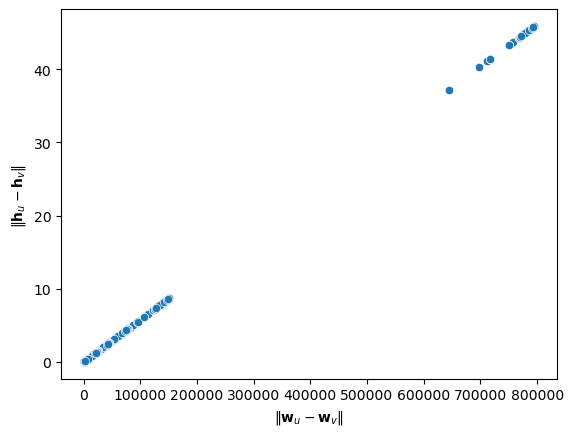

In [16]:
test_loader = DataLoader(test_set, batch_size=1)
walks = list()
for data in test_loader:
    G = to_networkx(data)
    w = sum_walks_degree(G, length=3)
    walks.append(w.reshape(-1, 1))
walks = np.vstack(walks)

idx = np.random.permutation(z_test.size(0))[:100]

z_test_subset = z_test[idx,:]
dist_gcn = torch.cdist(z_test_subset, z_test_subset).cpu().detach().numpy()

walks_subset = walks[idx,:]
dist_walks = euclidean_distances(walks_subset, walks_subset)

inds = np.triu_indices(100, k=1)
print(pearsonr(dist_gcn[inds], dist_walks[inds]))

g = sns.scatterplot(x=dist_walks[inds], y=dist_gcn[inds])
plt.xlabel(r"$\Vert \mathbf{w}_u - \mathbf{w}_v \Vert$")
plt.ylabel(r'$ \Vert \mathbf{h}_u - \mathbf{h}_v \Vert $ ')

### The Phenomenon of Oversquashing from Another Perspective

We create a dataset that consists of instances of the CBT(n,r) graph as discussed in the paper. We create two copies of each CBT(n,r) graph. The difference lies in the initial feature of a leaf of the balanced tree. While in the first copy (class 0), its value is equal to 1, in the second copy its value is equal to `feature`. In the following experiment we vary the value of `feature` from 5 to 100. The larger the value of the feature, the larger the value of $||\mathbf{w}_v^{(4)} - \mathbf{w}_{v'}{(4)}$ where $v$ and $v'$ are nodes of the complete graph in the two copies of CBT(n,r) respectively, and thus it is easier for the model to classify them to different categories.

In [17]:
class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_class, dropout=0.0):
        super().__init__()
        self.dropout = dropout
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(),
                            nn.BatchNorm1d(hidden_dim),nn.Linear(hidden_dim, hidden_dim), nn.ReLU())))                        
        for layer in range(n_layers-1):
            self.convs.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                            nn.BatchNorm1d(hidden_dim),nn.Linear(hidden_dim, hidden_dim), nn.ReLU()))) 
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        edge_index = data.edge_index
        x = data.x
        batch = data.batch

        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.dropout(x)

        idx = torch.zeros(torch.max(batch)+1, device=x.device, dtype=torch.long, requires_grad=False)
        _,counts = torch.unique(data.batch, return_counts=True)
        idx[1:] = counts[:-1]
        idx = torch.cumsum(idx, dim=0)
        out = self.relu(self.fc1(x[idx,:]))
        out = self.fc2(out)
        return out
    
generator = torch.Generator().manual_seed(42)

feature_vals = [5, 10, 20, 40, 60, 80, 100]
test_accs = list()
for feature in feature_vals:
    print('Feature of leaf node set to:', feature)
    print('----------------------------')
    dataset = list()
    for n in range(4,20):
        C = nx.complete_graph(n)
        for r in range(2,10):
            BT = nx.balanced_tree(r, 2)
            CBT = nx.disjoint_union(C, BT)
            CBT.add_edge(n-1, n)

            edge_index = torch.zeros(2, 2*CBT.number_of_edges(), dtype=torch.long)
            for j,edge in enumerate(CBT.edges()):
                edge_index[0,2*j] = edge[0]
                edge_index[1,2*j] = edge[1]
                edge_index[0,2*j+1] = edge[1]
                edge_index[1,2*j+1] = edge[0]
                
            x = torch.ones(CBT.number_of_nodes(), 1)
            dataset.append(Data(x=x, edge_index=edge_index, y=torch.tensor(0)))

            x = torch.ones(CBT.number_of_nodes(), 1)
            x[-1,:] = feature
            dataset.append(Data(x=x, edge_index=edge_index, y=torch.tensor(1)))            
    
    model = GIN(input_dim=1, hidden_dim=32, n_layers=4, n_class=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()
    
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [204, 26, 26], generator=generator)
        
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    
    best_val_loss = np.inf
    for epoch in range(301):
        model.train()
        loss_all = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, data.y)
            loss.backward()
            loss_all += data.num_graphs * loss.item()
            optimizer.step()
        train_loss = loss_all / len(train_loader.dataset)

        model.eval()
        loss_all = 0
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            loss = loss_func(output, data.y)
            loss_all += data.num_graphs * loss.item()
        val_loss = loss_all / len(val_loader.dataset)

        if best_val_loss >= val_loss:
            best_val_loss = val_loss

            correct = 0
            z_test = list()
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                pred = output.max(1)[1]
                correct += pred.eq(data.y).sum().item()
            test_acc = correct / len(test_loader.dataset)

        if epoch % 50 == 0:
            print('Epoch: {:03d}, Train Loss: {:.7f}, '
                    'Val Loss: {:.7f}, Test Acc: {:.7f}'.format(
                    epoch+1, train_loss, val_loss, test_acc))
            
    test_accs.append(test_acc)

Feature of leaf node set to: 5
----------------------------
Epoch: 001, Train Loss: 0.7161391, Val Loss: 0.6879695, Test Acc: 0.5000000
Epoch: 051, Train Loss: 0.6913623, Val Loss: 0.7206323, Test Acc: 0.5384615
Epoch: 101, Train Loss: 0.6914472, Val Loss: 0.7011819, Test Acc: 0.5384615
Epoch: 151, Train Loss: 0.6939490, Val Loss: 0.7033982, Test Acc: 0.5384615
Epoch: 201, Train Loss: 0.6918921, Val Loss: 0.7048012, Test Acc: 0.5384615
Epoch: 251, Train Loss: 0.6918240, Val Loss: 0.7087362, Test Acc: 0.5384615
Epoch: 301, Train Loss: 0.6971581, Val Loss: 0.7235772, Test Acc: 0.5384615
Feature of leaf node set to: 10
----------------------------
Epoch: 001, Train Loss: 0.6913777, Val Loss: 0.7617980, Test Acc: 0.4615385
Epoch: 051, Train Loss: 0.6909497, Val Loss: 0.7438825, Test Acc: 0.3461538
Epoch: 101, Train Loss: 0.6844921, Val Loss: 0.7567847, Test Acc: 0.3461538
Epoch: 151, Train Loss: 0.6881856, Val Loss: 0.7584114, Test Acc: 0.3461538
Epoch: 201, Train Loss: 0.6904749, Val Loss

We finally plot the accuracy achieved by GIN vs. the value of the feature of the leaf node.

Text(0, 0.5, 'Accuracy')

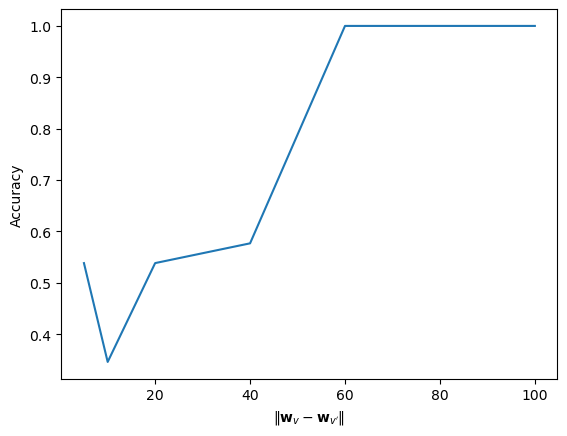

In [19]:
sns.lineplot(x=feature_vals, y=test_accs)
plt.xlabel(r"$\Vert \mathbf{w}_v - \mathbf{w}_{v'} \Vert$")
plt.ylabel('Accuracy')